<a href="https://colab.research.google.com/github/VMBoehm/N3ASProject_Annie/blob/main/ContrastiveLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Learning Code

In [1]:
!pip install git+https://github.com/VMBoehm/PytorchPAE.git@4Annie

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/VMBoehm/PytorchPAE.git (to revision 4Annie) to /tmp/pip-req-build-9wsxwoyn
  Running command git clone -q https://github.com/VMBoehm/PytorchPAE.git /tmp/pip-req-build-9wsxwoyn
  Running command git checkout -b 4Annie --track origin/4Annie
  Switched to a new branch '4Annie'
  Branch '4Annie' set up to track remote branch '4Annie' from 'origin'.
  Created wheel for pytorch-pae: filename=pytorch_pae-0.1.dev38+g4a13ed9-py3-none-any.whl size=14108 sha256=152035ee6a9f823e20c384648d0be3a2d887c6c7fe211a5334b8a13eff1ddbc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-4v99xy8_/wheels/78/cc/78/d3a54eac541cbd419347e36d065b35fb9a9740d1a9507e2b60
Successfully built pytorch-pae


In [2]:
# import this package 
from pytorch_pae import AE
from pytorch_pae import custom_transforms as ct
from pytorch_pae.data_loader import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
# import pytorch
import torch
print(torch.__version__)

1.11.0+cu113


In [5]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
from torchsummary import summary
from torchvision import transforms

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
!ls ./MyDrive/Junior_Year/N3AS/DR16_test.npy

ls: cannot access './MyDrive/Junior_Year/N3AS/DR16_test.npy': No such file or directory


In [9]:
tt = transforms.Compose(
    [
        ct.RandomMask(masked_frac=0.2) #orig value: 0.2 could try making this lower, 0.1
    ]
)
tt = ct.ContrastiveTransformations(tt)

## Step 1: Choose your parameters

In [10]:
SEED          = 287505

## data parameters
dataset       = 'SDSS_DR16_small_labeled'
loc           = 'drive/MyDrive/Junior_Year/N3AS/'
# number of layers in networks
n_layers     = 1

## fully connected net specific parameters
# output size of each fully connected layer
out_sizes    = [256]

## parameters that apply to both, fully connected and convolutional nets 
# dropout rate after each layer
dropout_rate = [0.0]
# whether to Lipschitz regularize by bounding the spectral norm 
spec_norm    = False
# activation function after each layer
activations  = ['ReLU']
# whether to add a bias in each layer or not
bias         = [True]
# whether tp apply a layer normalization after conv layer
layer_norm   = [False]
# whether to train elemntwise affine parameters for normalization layer 
affine       = False

## general parameters
# data dimensionality
dim          = '1D'
# latent space dimensionality
latent_dim   = 8 # originally 8, try changing, must be larger
hidden_dim   = 4 # originally 4, try changing
# number of channels in data
input_c      = 1 
# data dimensioality along one axis (only square data supported in 2D)
input_dim    = 1000
# type of encoder and decoder network (either 'fc' or 'conv')
encoder_type = 'fc'
decoder_type = 'fc'

# if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
final_sigmoid = False


## Training parameters
nepochs          = 10 # try 50
batchsize        = 512 # try changing sizes, original size 64
batchsize_valid  = 512
initial_lr       = 1e-2

optimizer        = 'Adam'
criterion1       = 'contrastive_loss'
criterion2       = 'contrastive_loss'

scheduler        = 'ExponentialLR'
scheduler_params = {'gamma':0.98}
ann_epoch        = 500

contrastive      = True
tau              = 0.05 # try changing, original value 0.05

In [11]:
general_params      = {'input_c': input_c, 'input_dim': input_dim, 'latent_dim': latent_dim, 'encoder_type': encoder_type, 'decoder_type': decoder_type, 'dim': dim, 'contrastive':contrastive, 'hidden_dim':hidden_dim, 'tau': tau}
fc_network_params   = {'n_layers': n_layers, 'out_sizes': out_sizes,'activations': activations, 'spec_norm': spec_norm, 'dropout_rate':dropout_rate, \
                       'layer_norm': layer_norm, 'affine': affine, 'final_sigmoid': final_sigmoid, 'bias':bias}
training_params     = {'batchsize': batchsize, 'initial_lr': initial_lr, 'optimizer': optimizer, 'criterion1': criterion1, 'criterion2': criterion2,
                       'scheduler': scheduler, 'scheduler_params':scheduler_params, 'ann_epoch': ann_epoch, 'batchsize_valid': batchsize_valid}
data_params         = {'dataset':dataset, 'loc': loc}

In [12]:
torch.manual_seed(SEED)
np.random.seed(SEED)

## Step 2: Set up and train the autoencoder

In [13]:
AE1 = AE.Autoencoder(general_params,data_params,fc_network_params, fc_network_params, training_params, device, tt)

In [14]:
test_sample = next(iter(AE1.valid_loader))

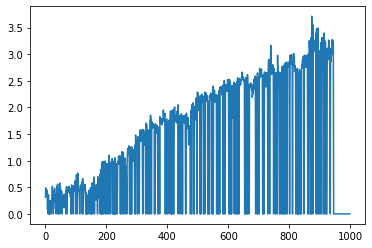

In [15]:
plt.plot(np.squeeze(test_sample[0][0]))

In [16]:
len(test_sample)

2

In [17]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 1000]               0
            Linear-2                  [-1, 256]         256,256
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                    [-1, 8]           2,056
         FCEncoder-6                    [-1, 8]               0
              ReLU-7                    [-1, 8]               0
            Linear-8                    [-1, 6]              54
              ReLU-9                    [-1, 6]               0
           Linear-10                    [-1, 4]              28
Total params: 258,394
Trainable params: 258,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.99
Estimated T

In [18]:
train_loss, valid_loss = AE1.train(nepochs)

epoch: 0, training loss: 4.2343e+00, validation loss: 3.4885e+00, learning rate: 9.8000e-03
epoch: 1, training loss: 3.1477e+00, validation loss: 2.8804e+00, learning rate: 9.6040e-03
epoch: 2, training loss: 2.8628e+00, validation loss: 2.7918e+00, learning rate: 9.4119e-03
epoch: 3, training loss: 2.6768e+00, validation loss: 2.6010e+00, learning rate: 9.2237e-03
epoch: 4, training loss: 2.5900e+00, validation loss: 2.5887e+00, learning rate: 9.0392e-03
epoch: 5, training loss: 2.5591e+00, validation loss: 2.5337e+00, learning rate: 8.8584e-03
epoch: 6, training loss: 2.5510e+00, validation loss: 2.5939e+00, learning rate: 8.6813e-03
epoch: 7, training loss: 2.5412e+00, validation loss: 2.5659e+00, learning rate: 8.5076e-03
epoch: 8, training loss: 2.5308e+00, validation loss: 2.5823e+00, learning rate: 8.3375e-03
epoch: 9, training loss: 2.5263e+00, validation loss: 2.5087e+00, learning rate: 8.1707e-03


In [19]:
# plt.figure()
# plt.title('Contrastive Learning Training',fontsize=14)
# plt.plot(train_loss, label='training')
# plt.plot(valid_loss, label='validation')
# plt.xlabel('epoch',fontsize=13)
# plt.ylabel('loss',fontsize=13)
# plt.legend(fontsize=13)
# plt.show()

In [20]:
# ### encoding network
# AE1.encoder

In [21]:
# encoded1= AE1(test_sample[0].to(AE1.device)).detach().cpu()
# encoded1.shape
# len(test_sample)
# test_sample[1]

In [22]:
# encoded2= AE1(test_sample[1].to(AE1.device)).detach().cpu()
# l1 = np.sqrt((encoded1[:,0] - encoded2[:,0])**2+(encoded1[:,1] - encoded2[:,1])**2+(encoded1[:,2] - encoded2[:,2])**2+(encoded1[:,3] - encoded2[:,3])**2)
# l2 = l1**2

# l1_avg = torch.mean(l1)
# l2_avg = torch.mean(l2)

# print(l1.shape)
# print(l1_avg)
# print(l2_avg)

In [23]:
# plt.scatter(encoded1[:,0].cpu(),encoded1[:,1])
# plt.scatter(encoded2[:,0].cpu(),encoded2[:,1],marker='+')
# # l1 & l2 (using encoded1 and encoded2 as point 1 and 2)
# # l1: |p1-p2|
# # 64 distances: take average or plot a histogram
# # 0.1 masked_frac
# # increase batch size of test (256, 512)

In [24]:
# # plt.plot(l1)
# # plt.show()

# plt.hist(l1, bins=200, density=True, cumulative=True)
# #plt.xlim([0,0.5])
# plt.show()

# sort = np.argsort(l1)
# print(sort.shape)

# plt.hist(l2, bins=1000, density=True, cumulative=True)
# #plt.xlim([0,0.1])
# plt.show()

# # plt.scatter(l2[:,0].cpu(),l2[:,1])
# # plt.show()

# # try batch size 512
# #print(np.argsort(l1))

In [25]:
# # top five shortest distances
# plt.plot(np.squeeze(test_sample[0][500]))
# plt.show()
# plt.plot(np.squeeze(test_sample[0][162]))
# plt.show()
# plt.plot(np.squeeze(test_sample[0][134]))
# plt.show()
# plt.plot(np.squeeze(test_sample[0][37]))
# plt.show()
# plt.plot(np.squeeze(test_sample[0][242])) # what's up with this one?
# plt.show()

In [26]:
# # top five largest distances
# plt.plot(np.squeeze(test_sample[0][504]))
# plt.show()
# plt.plot(np.squeeze(test_sample[0][243]))
# plt.show()
# plt.plot(np.squeeze(test_sample[0][377]))
# plt.show()
# plt.plot(np.squeeze(test_sample[0][496])) # what's up with this one?
# plt.show()
# plt.plot(np.squeeze(test_sample[0][110]))
# plt.show()

In [27]:
# classification model (similar to regression)
# l2 loss -> CSE loss
# This data "new data" put into classification NN

# Spectra Info:
  # red: no star formation or strong emission lines
  # H alpha line: if broad, due to velocity
    # doppler effect
    # b/c of merger 
    # and change in PE from high to low, emission from BH gas

In [ ]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],300,100, transforms=None)

# # Make device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
# devicea
# X, y = test_sample
# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     test_size=0.2, # 20% test, 80% train
#                                                     random_state=42) # make the random split reproducible
# # problem: y_train & y_test should be 1 dim
# print(X.shape)
# print(y.shape)

In [ ]:
next(iter(train_loader))
torch.save(model, loc)
model = torch.load(loc)

In [ ]:
i = 0
data_len = dataset.len

while batchsize * i <= data_len:
  batch = next(data_loader) #written as iterator
  enc = model(batch["features"])
  label = batch["labels"]
  i += 1
  encs.append(enc)
  labels.append(label)